# Network analysis

* This notebook uses fastquant to retrieve recent PH stock data 
* Then we implement stock network analysis, based on Dr. Legara's notebook [here](https://github.com/eflegara/FinancialNetwork/blob/master/Financial%20Network.ipynb), which includes:
  * Setting up the correlation matrix for the stock prices in the Philippine Stock Exchange
  * Converting the resulting correlation matrix into a distance matrix
  * Building a minimum spanning tree from the distance matrix
* The end result is a visual representation of network tree
* PSE-listed company names are taken from [PSE](https://pse.com.ph/stockMarket/marketInfo-marketActivity.html?tab=1&indexName=All%20Shares) and saved as csv file.

In [1]:
%matplotlib inline
import matplotlib as mpl
mpl.style.use("default")

import numpy as np
import pandas as pd
import matplotlib.pyplot as pl
import seaborn as sb
import networkx as nx

from fastquant import get_pse_data_cache, get_stock_data

## pull stock data using fastquant 

In [2]:
df = get_pse_data_cache()
df.tail()

Symbol       2GO                              AAA                       ...  \
            open  high   low close     value open high low close value  ...   
dt                                                                      ...   
2020-04-06  5.98  6.01  5.98  6.00  202096.0  NaN  NaN NaN   NaN   NaN  ...   
2020-04-07  6.14  6.20  5.50  5.90  868780.0  NaN  NaN NaN   NaN   NaN  ...   
2020-04-08  5.95  5.95  5.87  5.87  112547.0  NaN  NaN NaN   NaN   NaN  ...   
2020-04-13  5.93  6.14  5.85  5.89  508920.0  NaN  NaN NaN   NaN   NaN  ...   
2020-04-14  6.14  6.14  6.00  6.06  334680.0  NaN  NaN NaN   NaN   NaN  ...   

Symbol        WPI                                   ZHI                       \
             open   high    low  close     value   open   high    low  close   
dt                                                                             
2020-04-06  0.390  0.390  0.390  0.390   27300.0  0.130  0.130  0.130  0.130   
2020-04-07  0.395  0.450  0.395  0.430  547550.0  0.124  0.139  0.124  0.135   
2020-04-08  0.415  0.415  0.415  0.415  120350.0  0.132  0.132  0.132  0.132   
2020-04-13  0.410  0.410  0.385  0.400  172150.0  0.132  0.132  0.125  0.125   
2020-04-14  0.400  0.420  0.400  0.420   41000.0  0.125  0.133  0.123  0.126   

Symbol                
               value  
dt                    
2020-04-06   33800.0  
2020-04-07  134530.0  
2020-04-08   55440.0  
2020-04-13   72860.0  
2020-04-14   86600.0  

[5 rows x 1260 columns]

In [3]:
#choose only close column
df = df.xs('close', level=1, axis=1)
df.head()

Symbol,2GO,AAA,AB,ABA,ABG,ABS,AC,ACE,ACEPH,ACEX,...,VITA,VLL,VMC,VUL,VVT,WEB,WIN,WLCON,WPI,ZHI
dt,,,,,,,,,,,,,,,,,,,,,
2010-01-04,NaN,0.57,100.0,0.87,NaN,29.0,300.0,NaN,1.20,NaN,...,0.40,1.90,NaN,0.61,NaN,18.00,0.120,NaN,0.3,0.200
2010-01-05,1.14,0.46,100.0,0.87,NaN,29.0,300.0,NaN,1.26,NaN,...,0.40,1.88,NaN,0.68,NaN,18.25,0.120,NaN,NaN,0.210
2010-01-06,1.14,NaN,99.5,0.83,NaN,29.0,300.0,3.45,1.30,NaN,...,0.39,1.90,NaN,NaN,NaN,18.25,0.120,NaN,NaN,0.215
2010-01-07,1.14,0.42,100.0,0.84,NaN,29.0,297.5,3.00,1.26,NaN,...,0.41,1.92,NaN,NaN,NaN,18.25,0.115,NaN,0.3,0.200
2010-01-08,1.16,0.48,98.0,0.86,NaN,29.0,297.5,2.90,1.28,NaN,...,NaN,2.00,NaN,0.66,NaN,18.25,0.115,NaN,NaN,0.220


In [4]:
#choose recent data
df = df[(df.index >= '2019-1-1') & (df.index <= '2020-1-1')]
df

Symbol,2GO,AAA,AB,ABA,ABG,ABS,AC,ACE,ACEPH,ACEX,...,VITA,VLL,VMC,VUL,VVT,WEB,WIN,WLCON,WPI,ZHI
dt,,,,,,,,,,,,,,,,,,,,,
2019-01-02,13.58,NaN,15.44,0.64,26.20,20.05,906.0,1.40,1.15,3.39,...,1.92,5.41,2.33,1.54,NaN,3.82,0.260,13.06,0.77,0.220
2019-01-03,14.56,NaN,15.48,0.69,28.40,20.20,925.0,1.37,1.15,3.40,...,1.94,5.46,NaN,1.63,NaN,3.59,0.275,12.90,0.78,0.226
2019-01-04,14.34,NaN,16.50,0.71,27.50,20.35,960.0,1.34,1.16,NaN,...,1.94,5.60,NaN,1.66,NaN,3.45,0.260,13.40,0.77,0.226
2019-01-07,14.08,NaN,15.90,0.72,27.40,20.90,998.0,1.38,1.30,3.40,...,1.88,5.69,NaN,1.62,NaN,3.55,0.255,14.00,0.78,0.224
2019-01-08,15.02,NaN,15.50,0.70,28.15,21.50,970.0,1.37,NaN,NaN,...,1.90,5.65,NaN,1.64,NaN,3.45,0.248,13.74,0.78,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-19,9.48,NaN,10.92,0.78,10.68,15.80,755.0,NaN,2.31,7.15,...,1.13,7.35,NaN,0.88,15.30,2.35,0.202,18.16,0.57,0.190
2019-12-20,9.42,NaN,NaN,0.82,10.76,15.82,779.5,1.49,2.31,7.20,...,1.12,7.30,NaN,0.89,15.14,2.43,NaN,17.84,0.60,0.209
2019-12-23,9.78,NaN,10.96,0.87,10.82,15.80,779.0,1.49,2.27,7.15,...,1.17,7.35,2.57,0.88,NaN,2.40,NaN,17.70,0.61,0.190


In [5]:
#remove columns with NaNs
df.dropna(axis=1, inplace=True)

## Build correlation matrix

In [6]:
price_corr = df.corr()

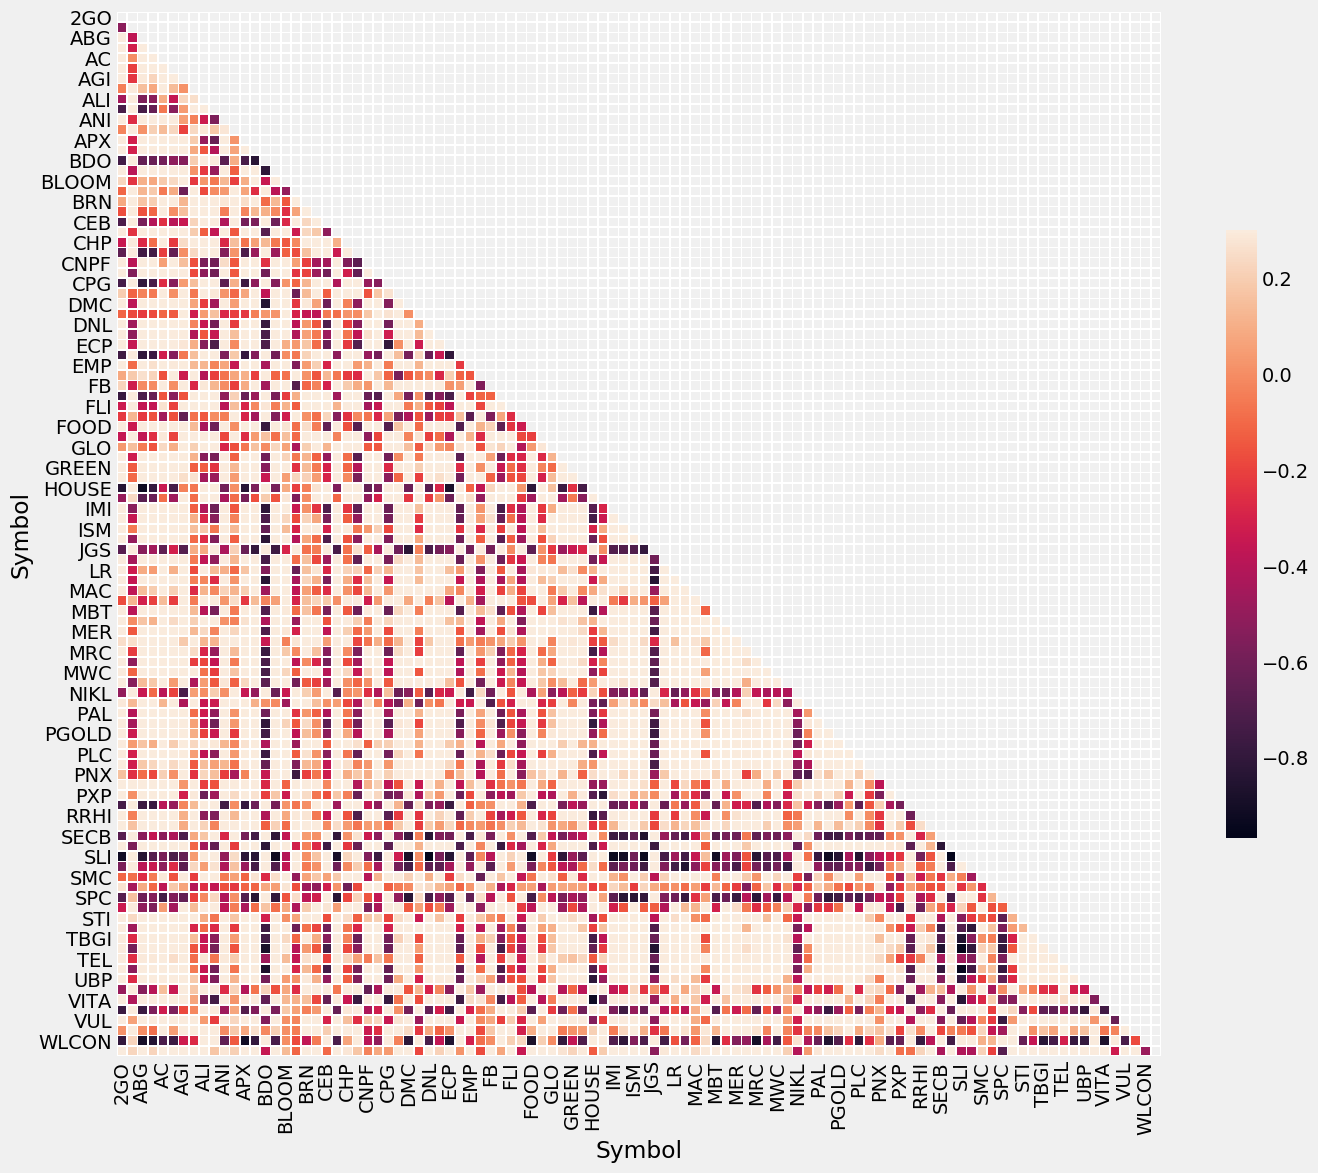

In [7]:
## Source: https://stanford.edu/~mwaskom/software/seaborn/examples/many_pairwise_correlations.html

## Generate a mask for the upper triangle
mask = np.zeros_like(price_corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

## Set up the matplotlib figure
fig, ax = pl.subplots(figsize=(15, 15))

## Generate a custom diverging colormap
# cmap = sb.diverging_palette(220, 10, as_cmap=True)

## Draw the heatmap with the mask and correct aspect ratio
sb.heatmap(price_corr, mask=mask, vmax=.3, #cmap=cmap,
            square=True, xticklabels=2, yticklabels=2,
            linewidths=.5, cbar_kws={"shrink": .5}, ax=ax
          )

In [8]:
def plot_corr(symbol, positive=True, rescale=True):
    corr = price_corr[symbol].sort_values(ascending=True)
    
    fig, ax = pl.subplots(1,2, figsize=(10,5))
    
    if positive:
        symbol2 = corr.index[-2]
    else:
        symbol2 = corr.index[0]
        
    if rescale:
        d1 = df[symbol]/df[symbol].max()
        d2 = df[symbol2]/df[symbol2].max()
        _ = d1.plot(ax=ax[0], label=symbol)
        d2.apply(lambda x: x).plot(ax=ax[0], label=symbol2)
    else:
        _ = df[symbol].plot(ax=ax[0], label=symbol)
        df[symbol2].plot(ax=ax[0], label=symbol2)
    ax[0].legend()

    ax[1].plot(df[symbol], df[symbol2], 'o')
    pl.setp(ax[1], xlabel=symbol, ylabel=symbol2)
    return fig    

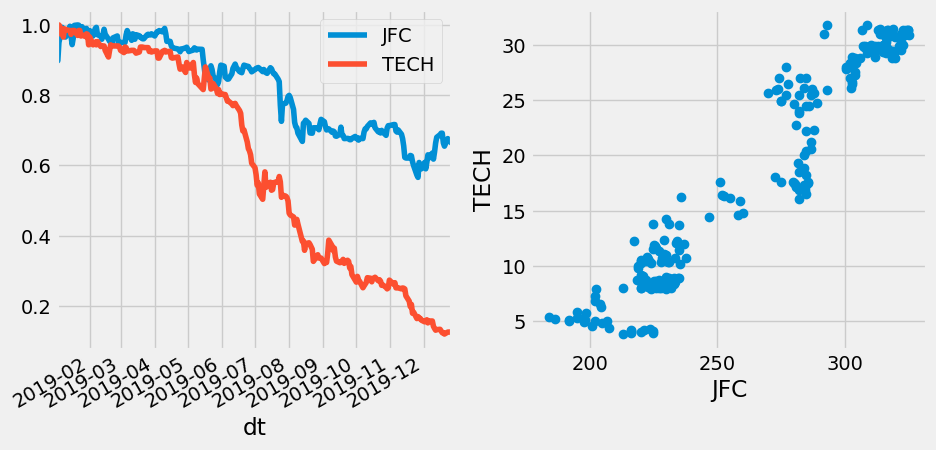

In [9]:
fig = plot_corr('JFC', positive=True);

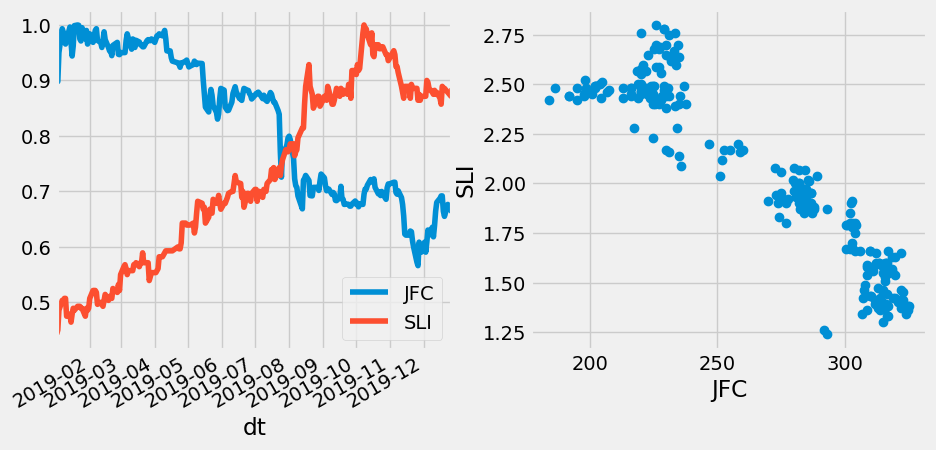

In [10]:
fig = plot_corr('JFC', positive=False);

## build distance matrix

In [11]:
dist_bonanno = np.sqrt(2*(1-(price_corr)))
dist_mktstk = 1-abs(price_corr)

## I am just defining the labels
labs_bonanno = list(dist_bonanno.index)
labs_mktstk = list(dist_mktstk.index)

## build minimum spanning tree

In [12]:
G_bonanno = nx.from_numpy_matrix(dist_bonanno.values)
G_mktstk = nx.from_numpy_matrix(dist_mktstk.values)

In [13]:
MST_b = nx.minimum_spanning_tree(G_bonanno)  
MST_m = nx.minimum_spanning_tree(G_mktstk) 

In [14]:
stock_table = pd.read_csv('../data/stock_table.csv')
stock_table.head()

,Company Name,Stock Symbol,Sector,Subsector,Listing Date,company_id,security_id
0,"2GO Group, Inc.",2GO,Services,Transportation Services,"May 15, 1995",29,146
1,"8990 Holdings, Inc.",HOUSE,Property,Property,"Dec 09, 2010",626,563
2,"A Brown Company, Inc.",BRN,Property,Property,"Feb 08, 1994",13,234
3,A. Soriano Corporation,ANS,Holding Firms,Holding Firms,"Oct 25, 1973",14,169
4,ABS-CBN Corporation,ABS,Services,Media,"Jul 08, 1992",114,123


In [15]:
MST_b.nodes

NodeView((0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101))

In [16]:
change = (df.iloc[-1] - df.iloc[0]) * 100 / df.iloc[0]

In [17]:
change

Symbol
2GO     -22.680412
ABA      34.375000
ABG     -60.076336
ABS     -21.197007
AC      -13.300221
           ...    
VLL      42.883549
VUL     -44.155844
WEB     -31.675393
WLCON    37.825421
WPI     -22.077922
Length: 102, dtype: float64

In [18]:
for node in MST_b.nodes():
    sector = stock_table[stock_table["Stock Symbol"] == labs_bonanno[node]].Sector.iloc[0]
    MST_b.nodes[node]["sector"] = sector
    MST_b.nodes[node]["label"] = labs_bonanno[node]
    if np.isnan(change[labs_bonanno[node]]):
        MST_b.nodes[node]["color"] = "black"
    elif change[labs_bonanno[node]] < -10:
        MST_b.nodes[node]["color"] = "red"
    elif change[labs_bonanno[node]] > 10:
        MST_b.nodes[node]["color"] = "green"
    else:
        MST_b.nodes[node]["color"] = "blue"

In [19]:
for node in MST_m.nodes():
    sector = stock_table[stock_table["Stock Symbol"] == labs_mktstk[node]].Sector.iloc[0]
    MST_m.nodes[node]["sector"] = sector
    MST_m.nodes[node]["label"] = labs_mktstk[node]
    if np.isnan(change[labs_mktstk[node]]):
        #print change[labs_mktstk[node]], labs_mktstk[node]
        #Gm.node[node]["change"] = 101
        MST_m.nodes[node]["color"] = "black"
    elif change[labs_mktstk[node]] < -10:
        MST_m.nodes[node]["color"] = "red"
    elif change[labs_mktstk[node]] > 10:
        MST_m.nodes[node]["color"] = "green"
    else:
        MST_m.nodes[node]["color"] = "blue"

In [20]:
stock_table.Sector.unique()

array(['Services', 'Property', 'Holding Firms', 'Industrial',
       'Mining and Oil', 'Financials', 'ETF-Equity',
       'Small, Medium & Emerging Board'], dtype=object)

## Drawing MSTs

Text(0.5, 0.98, 'bonano')

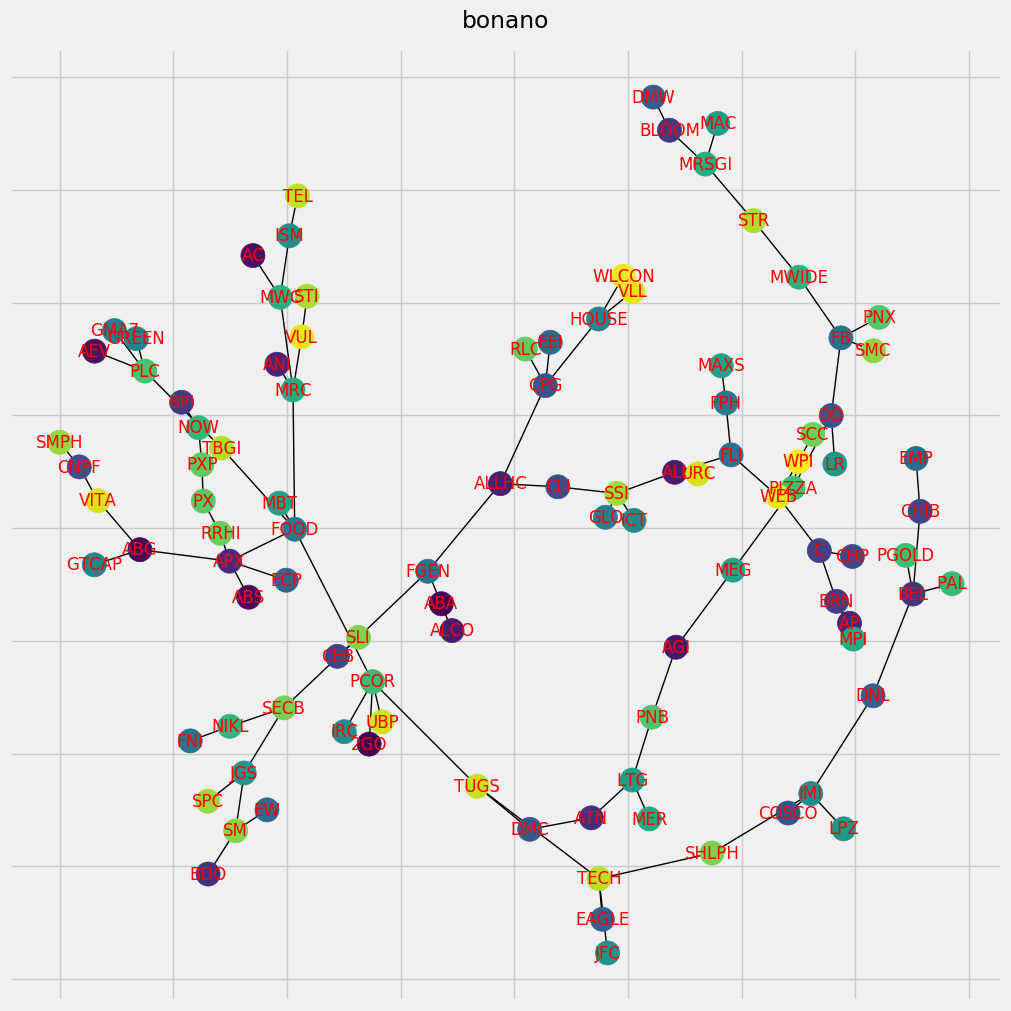

In [21]:
fig = pl.figure(figsize=(10,10), constrained_layout=True)
nx.draw_networkx(MST_b, 
                 pos=nx.spring_layout(MST_b),
                 labels=nx.get_node_attributes(MST_b, 'label'),
                 node_color=range(len(MST_b)),
                 cmap='viridis', #pl.get_cmap("Blues"),
                 font_color='r'
                )
fig.suptitle('bonano')

Text(0.5, 0.98, 'mktstk')

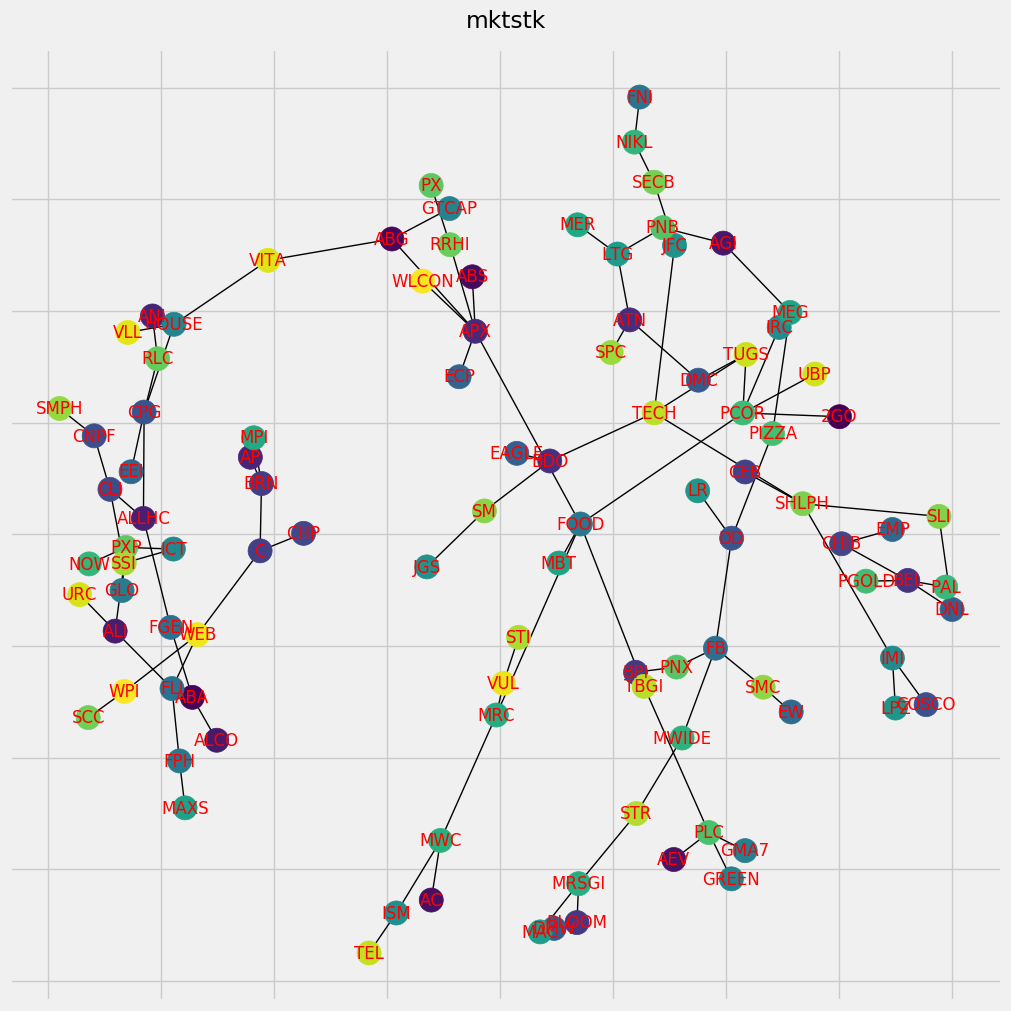

In [22]:
fig = pl.figure(figsize=(10,10), constrained_layout=True)
nx.draw_networkx(MST_m,
                 pos=nx.spring_layout(MST_m),
                 labels=nx.get_node_attributes(MST_m, 'label'),
                 node_color=range(len(MST_m)),
                 cmap='viridis', #pl.get_cmap("Blues"),
                 font_color='r'
                )
fig.suptitle('mktstk')

### Write out MSTs

In [22]:
nx.write_gexf(MST_b, "../data/corrmat_bonanno.gexf")
nx.write_gexf(MST_m, "../data/corrmat_mktstk.gexf")

Below is the resulting network (`MST_b`) drawn using Gephi.
![MST Bonanno](../data/network.jpg)

# using sklearn (under development)
* https://scikit-learn.org/stable/auto_examples/applications/plot_stock_market.html#sphx-glr-auto-examples-applications-plot-stock-market-py

In [2]:
import pandas as pd

bluechips = pd.read_csv('../data/bluechips.txt', delimiter='\t', names=['symbol','name'])
bluechips.head()

,symbol,name
0,DMC,"DMCI Holdings, Inc."
1,SCC,Semirara Mining and Power Corporation
2,AGI,"Alliance Global Group, Inc."
3,LTG,"LT Group, Inc."
4,MPI,Metro Pacific Investments Corporation


In [3]:
from fastquant import get_pse_data_cache, get_stock_data

cache = get_pse_data_cache()

#drop non-bluechips stocks
is_bluechips = cache.columns.levels[0].isin(bluechips.symbol)
columns = cache.columns.levels[0][~is_bluechips]
cache = cache.drop(columns=columns, level=0)

#choose recent data
df = cache[(cache.index > '2019-1-1') & (cache.index <= '2020-1-1')]
#drop stocks with NaNs
df.dropna(axis=1, inplace=True)
df.head()

Symbol         AC                                      AEV                \
             open   high    low  close        value   open   high    low   
dt                                                                         
2019-01-02  904.0  914.0  901.0  906.0  274766700.0  55.00  56.00  52.30   
2019-01-03  913.5  932.0  907.5  925.0  635455000.0  54.75  56.50  53.35   
2019-01-04  930.0  970.0  925.0  960.0  758288700.0  55.70  59.55  55.70   
2019-01-07  965.0  998.0  965.0  998.0  773563980.0  58.25  59.20  57.20   
2019-01-08  994.0  994.0  957.0  970.0  298600815.0  58.00  58.60  57.20   

Symbol                         ...     TEL                          \
           close        value  ...    open    high     low   close   
dt                             ...                                   
2019-01-02  53.2   34863909.5  ...  1169.0  1169.0  1128.0  1130.0   
2019-01-03  56.5   57355705.0  ...  1139.0  1164.0  1134.0  1158.0   
2019-01-04  57.0  108420152.0  ...  1158.0  1185.0  1148.0  1160.0   
2019-01-07  57.2   59546580.0  ...  1160.0  1192.0  1148.0  1148.0   
2019-01-08  57.2   47004339.0  ...  1162.0  1177.0  1140.0  1140.0   

Symbol                     URC                                    
                  value   open   high    low  close        value  
dt                                                                
2019-01-02   32717665.0  128.4  128.5  125.7  127.5   37946221.0  
2019-01-03   93279400.0  127.5  128.8  127.2  128.5  125876349.0  
2019-01-04  104563580.0  128.5  130.5  127.5  128.5  448165602.0  
2019-01-07   85935155.0  129.5  131.7  129.3  130.5  357013830.0  
2019-01-08   48524835.0  131.0  131.3  129.5  130.0  222373222.0  

[5 rows x 150 columns]

In [ ]:
import numpy as np
import matplotlib.pyplot as pl
from matplotlib.collections import LineCollection

import pandas as pd

from sklearn import cluster, covariance, manifold


open_prices = df.xs('open', level=1, axis=1)
close_prices = df.xs('close', level=1, axis=1)

# The daily variations of the quotes are what carry most information
variation = close_prices - open_prices


# #############################################################################
# Learn a graphical structure from the correlations
edge_model = covariance.GraphicalLassoCV()

# standardize the time series: using correlations rather than covariance
# is more efficient for structure recovery
X = variation.copy().T
X /= X.std(axis=0)
edge_model.fit(X)

# #############################################################################
# Cluster using affinity propagation

_, labels = cluster.affinity_propagation(edge_model.covariance_)
n_labels = labels.max()

for i in range(n_labels + 1):
    print('Cluster {:d}: {}'.format((i + 1), ', '.join(names[labels == i])))

# #############################################################################
# Find a low-dimension embedding for visualization: find the best position of
# the nodes (the stocks) on a 2D plane

# We use a dense eigen_solver to achieve reproducibility (arpack is
# initiated with random vectors that we don't control). In addition, we
# use a large number of neighbors to capture the large-scale structure.
node_position_model = manifold.LocallyLinearEmbedding(
    n_components=2, eigen_solver='dense', n_neighbors=6)

embedding = node_position_model.fit_transform(X.T).T

(-0.20017287981886075, 0.13998097162034456)

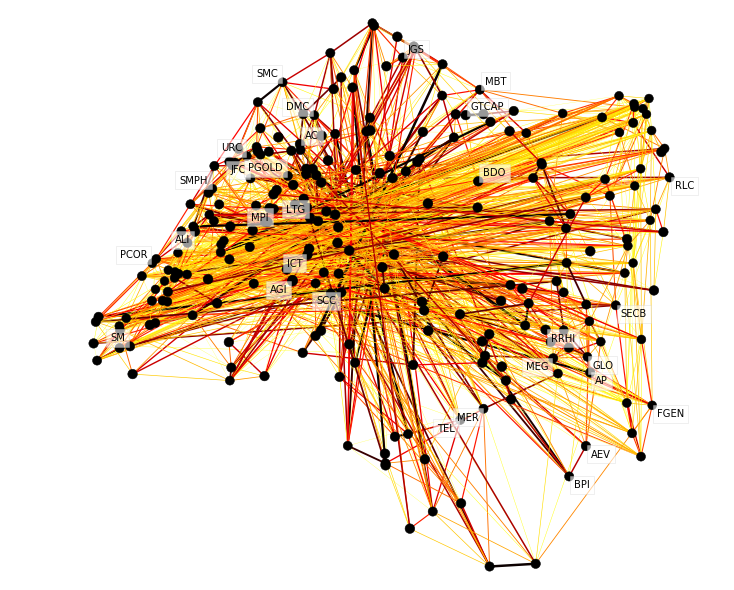

In [5]:
# #############################################################################
# Visualization
pl.figure(1, facecolor='w', figsize=(10, 8))
pl.clf()
ax = pl.axes([0., 0., 1., 1.])
pl.axis('off')

# Display a graph of the partial correlations
partial_correlations = edge_model.precision_.copy()
d = 1 / np.sqrt(np.diag(partial_correlations))
partial_correlations *= d
partial_correlations *= d[:, np.newaxis]
non_zero = (np.abs(np.triu(partial_correlations, k=1)) > 0.02)

# Plot the nodes using the coordinates of our embedding
pl.scatter(embedding[0], embedding[1], s=100 * d ** 2, c=labels,
            cmap=pl.cm.nipy_spectral)

# Plot the edges
start_idx, end_idx = np.where(non_zero)
# a sequence of (*line0*, *line1*, *line2*), where::
#            linen = (x0, y0), (x1, y1), ... (xm, ym)
segments = [[embedding[:, start], embedding[:, stop]]
            for start, stop in zip(start_idx, end_idx)]
values = np.abs(partial_correlations[non_zero])
lc = LineCollection(segments,
                    zorder=0, cmap=pl.cm.hot_r,
                    norm=pl.Normalize(0, .7 * values.max()))
lc.set_array(values)
lc.set_linewidths(15 * values)
ax.add_collection(lc)

# Add a label to each node. The challenge here is that we want to
# position the labels to avoid overlap with other labels
for index, (name, label, (x, y)) in enumerate(
        zip(bluechips.symbol, labels, embedding.T)):

    dx = x - embedding[0]
    dx[index] = 1
    dy = y - embedding[1]
    dy[index] = 1
    this_dx = dx[np.argmin(np.abs(dy))]
    this_dy = dy[np.argmin(np.abs(dx))]
    if this_dx > 0:
        horizontalalignment = 'left'
        x = x + .002
    else:
        horizontalalignment = 'right'
        x = x - .002
    if this_dy > 0:
        verticalalignment = 'bottom'
        y = y + .002
    else:
        verticalalignment = 'top'
        y = y - .002
    pl.text(x, y, name, size=10,
             horizontalalignment=horizontalalignment,
             verticalalignment=verticalalignment,
             bbox=dict(facecolor='w',
                       edgecolor=pl.cm.nipy_spectral(label / float(n_labels)),
                       alpha=.6))

pl.xlim(embedding[0].min() - .15 * embedding[0].ptp(),
         embedding[0].max() + .10 * embedding[0].ptp(),)
pl.ylim(embedding[1].min() - .03 * embedding[1].ptp(),
         embedding[1].max() + .03 * embedding[1].ptp())